In [77]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.ticker import MaxNLocator

import feather

from tqdm import tqdm_notebook as tqdm

from tqdm import tqdm_pandas

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

from multiprocessing import Pool

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing

from pathlib import Path

# import plaidml.keras

# plaidml.keras.install_backend()

import keras
from keras.preprocessing import sequence
from keras import layers, Input, Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, LSTM, Dropout, TimeDistributed

import tensorflow as tf

In [2]:
mtx = np.load("st_offsets_medians(1,10)_t_off(0,4)_w_off(-1,2_thresh_3).npy")

NameError: name 'se' is not defined

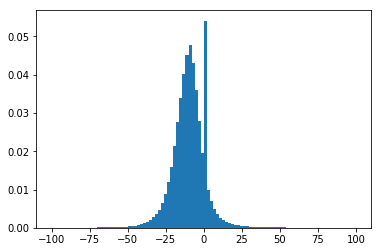

In [3]:
plt.hist(mtx.ravel(), bins=100, range=(-100,100), density=True);
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-100,100), alpha=0.5, density=True);

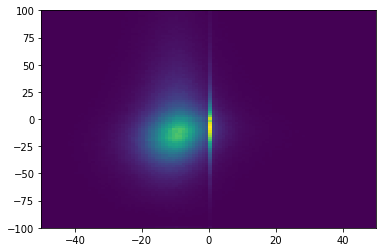

In [11]:
plt.hist2d(mtx.mean(axis=(1,2)), se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], range=[[-50,50],[-100,100]], bins=[100,100]);

## Loading and setting up the data

In [4]:
se = feather.read_dataframe("../../data_files/B/once/75days/stop_events_with_geo_train_test_averages_prev_next_dwell.feather",
                            columns=["index",
                                     "segment_duration",
                                     "mean_durations_by_segment_code",
                                     "mean_durations_by_segment_code_and_hour_and_day",
                                     "diff_segment_and_mean_by_segment_code",
                                     "diff_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'line_distance',
                                     'to_centre_dist',
                                     'direction_degrees',
                                     'rain',
                                     'median_durations_by_segment_code_and_hour_and_day',
                                     'arrival_hour','arrival_day',
                                     "diff_percent_segment_and_mean_by_segment_code_and_hour_and_day",
                                     'date','workid',
                                     'actualArrival'
                                    ])
se = se.set_index(se.columns[0])

In [6]:
 # And now for just segments:
se["diff_segment_and_mean_by_segment_code"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code"]
)
se["diff_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["segment_duration"]
    - se["mean_durations_by_segment_code_and_hour_and_day"]
)

se["diff_percent_segment_and_mean_by_segment_code"] = (
    se["diff_segment_and_mean_by_segment_code"]
    * 100
    / se["mean_durations_by_segment_code"]
)

se["diff_percent_segment_and_mean_by_segment_code_and_hour_and_day"] = (
    se["diff_segment_and_mean_by_segment_code_and_hour_and_day"]
    * 100
    / se["mean_durations_by_segment_code_and_hour_and_day"]
)

## Settings

In [12]:
data_size = 2000000
data_mask = np.zeros(se.shape[0]).astype(bool)

data_mask[:data_size] = True

train = False
test = False

if train:
    data_mask = se['train']
    
if test: 
    data_mask = se['test']

data_size = np.count_nonzero(data_mask)


In [ ]:
print(data_size)

In [ ]:
test_matrix = np.load(f"percentage_offsets_check.npy").T

In [ ]:
test_matrix.shape

In [ ]:
(test_matrix[:,0].astype(int)[500000:2000000] == se.index.values[500000:2000000]).all()

In [ ]:
(test_matrix[data_mask,1] == se.loc[:,'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'][data_mask].values).all()


In [ ]:
# test_length = np.count_nonzero(se['test'])

# test_mask = se['test']

In [ ]:
# 1st dimention is number of data points
# 2nd dimention is going back in time (in 10 min increments)
# 3rd dimention is prev-next segments

width_array = [
             'prev_segment_code_11',
             'prev_segment_code_10',
             'prev_segment_code_9',
             'prev_segment_code_8',
             'prev_segment_code_7',
             'prev_segment_code_6',
             'prev_segment_code_5', 
             'prev_segment_code_4', 
             'prev_segment_code_3', 
             'prev_segment_code_2', 
             'prev_segment_code_1', 
             'segment_code',
             'next_segment_code_1',
             'next_segment_code_2',
             'next_segment_code_3',
             'next_segment_code_4',
             'next_segment_code_5',
             'next_segment_code_6',
             'next_segment_code_7',
             'next_segment_code_8',
             'next_segment_code_9',
             'next_segment_code_10',
             'next_segment_code_11',
            ]

means = np.empty((data_size, 25, len(width_array))).astype(float)
counts = np.empty((data_size, 25, len(width_array))).astype(int)

index = np.empty((data_size)).astype(int)

for idx, code in enumerate(tqdm(width_array)):
    
    matrix = np.load(f"mtx_{code}_last_25_10_2nd.npy")
    
#     matrix = matrix[se.index.values[:np.argmax(se.index.values>=3920086)],:]
    

    means[:,:,idx] = matrix[data_mask,1:26].astype(float)
    counts[:,:,idx] = matrix[data_mask,26:].astype(int)
    
    if idx == 0:
        index = matrix[data_mask,0].astype(int)
            
#     print(".", end="", flush=True)
        
  
    

In [ ]:
np.max(counts)

In [ ]:

print((index == se.index[data_mask]).all())


In [13]:
def calc_slice(width, time, width_offset=0, time_offset=0, additional_prev=0):
    centre = int(len(width_array)/2) + 1
    centre += width_offset
    
    return np.s_[:,2+time_offset:time+3+time_offset,centre-width-additional_prev:centre+width+1]


In [14]:
def calc_offsets(means, counts, slices, axis, column_name, mask_threshold):
    
    mask = np.sum(counts[slices], axis=axis) > mask_threshold
    
    threshold_pass_fraction = np.count_nonzero(mask)/len(mask)
    
    if  threshold_pass_fraction < 0.25:
        raise ValueError('not enough data passing threshold')
    
    print(f"Approximately {threshold_pass_fraction*100:0.2f}% pass the threshold")
    
    data = means[slices][mask]
    
    weights = counts[slices][mask]
    
    masked_data = np.ma.masked_array(data, np.isnan(data))
    
    if column_name is not None:    
        se[column_name] = 0

        se.loc[mask, column_name] = np.ma.average(masked_data, axis=axis, weights=weights)
        
        return
    
    offsets = np.zeros(counts.shape[0])
    
    offsets[mask] = np.ma.average(masked_data, axis=axis, weights=weights)
    
    return offsets, threshold_pass_fraction, np.mean(np.sum(weights, axis=axis))

In [ ]:
plt.hist(se['diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'], bins=100, range=(-150,150));
# plt.hist(se['full_mean_minus_recent_15'], bins=100, range=(-150,150), alpha=0.5);

In [ ]:
#Width of 2 and time of 100 with a threshold of 40

calc_slice(2,10)

bus_counts = np.sum(counts[calc_slice(2,10)], axis=(1,2))

dense_mask = (bus_counts>=40)

print(f"Fraction over 40: {(bus_counts>=40).sum()/bus_counts.shape[0]}")

In [ ]:
plt.hist(bus_counts, bins=20, range=(0,200), density=True);
plt.xlabel("Number of buses")
plt.ylabel("Fraction")
plt.title("Number of data points for last 220 mins (minus the most recent 20)\nincl 2 prev & 2 next segments")

In [ ]:
# 1st Dimension is length of data points
# 2nd dimension is going back in time
# 3rd dimention is prev-next

# Thoughts on the defaults:
# - Set to zero (fast but doesn't contain much data)
# - Set to v sparce prediction (probably better)
# - Try to predict diff between v sparse mean and truth, 
#              set empty to zero and values to diff from 
#              v sparse mean

# Other ideas:
# - When making the offsets going one stop further previous than next 
#              (as prev' seems to be a better predictor)
# - Try a stride length of 2 both in time and down the road
# - Try a little less dense...
st_offsets_dense = np.zeros((data_size, 11, 11))

for i in range(11):
    for j in range(-5,6,1):

        st_offsets_dense[:,i,j+3], _, _ = calc_offsets(means, counts, calc_slice(2,10,j,i), (1,2), None, 60)
        




In [ ]:
# 1st Dimension is length of data points
# 2nd dimension is going back in time
# 3rd dimention is prev-next


st_offsets_dense_plus_prev = np.zeros((data_size, 11, 11))

for i in range(11):
    for j in range(-5,6,1):

        st_offsets_dense_plus_prev[:,i,j+3], _, _ = calc_offsets(means, counts, calc_slice(2,10,j,i,1), (1,2), None, 60)
        





In [ ]:
offsets_sparse2, _, _ = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)

In [ ]:
offsets_dense2 = st_offsets_dense[:,0,5]

In [ ]:
np.save("bus_counts(2,10)", bus_counts)

In [ ]:
np.save("offsets_sparse2(10,20)", offsets_sparse2)

In [ ]:
np.save("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)", st_offsets_dense)

In [ ]:
np.save("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)_1prev", st_offsets_dense_plus_prev)

In [24]:
# st_offsets_dense = np.load("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6).npy")
st_offsets_dense = np.load("st_offsets_medians(1,10)_t_off(0,4)_w_off(-1,2_thresh_3).npy")

bus_counts = np.load("bus_counts(2,10).npy")
offsets_sparse2 = np.load("offsets_sparse2(10,20).npy")
st_offsets_dense_plus_prev = np.load("st_offsets_dense(2,10)_t_off(0,11)_w_off(-5,6)_1prev.npy")
offsets_dense2 = st_offsets_dense[:,0,int((st_offsets_dense.shape[2]-1)/2)]

In [25]:
st_offsets_dense = st_offsets_dense[:data_size]
offsets_dense2 = offsets_dense2[:data_size]

In [26]:
st_offsets_dense

array([[[ 10.59117295,  14.17475728,  20.72374228],
        [  9.39096267,   4.66019417,   4.30960086],
        [  9.39096267,   4.66019417,   4.30960086],
        [  0.        ,   0.        ,   0.        ]],

       [[ 14.17475728,  14.17475728,   8.77630244],
        [  4.66019417,  -1.08885398,  -6.8217145 ],
        [  4.66019417,  -1.08885398,  -6.8217145 ],
        [  0.        ,   0.        ,   0.        ]],

       [[ 14.17475728,   3.3778476 ,   0.85093498],
        [ -1.08885398,  -5.00823818,  -5.00823818],
        [ -1.08885398,  -5.00823818,  -5.00823818],
        [  0.        ,   0.        ,   0.        ]],

       ...,

       [[ -1.55440415,  -1.18694362,   0.        ],
        [ -1.55440415,  -1.18694362,   0.        ],
        [ -1.55440415,  -1.55440415,  -2.97202797],
        [ -1.55440415,  -2.97202797,  -6.17283951]],

       [[ -1.18694362,  -6.17283951, -12.80532939],
        [ -1.18694362,  -9.48908445, -12.8542776 ],
        [ -1.55440415, -12.80532939, -14.40

In [28]:
print(f"Percent nonzero:{np.count_nonzero(st_offsets_dense)/st_offsets_dense.size*100}")

Percent nonzero:92.06272083333333


In [29]:
# make a copy and then in that copy replace all zeros with the sparse prediction instead. 
# Technically there might be a few zeros that are actually valid means but the chance of 
# a mean being exactly zero is quite small. 

offsets_sparse2_big = np.empty(st_offsets_dense.shape)

offsets_sparse2_big[:] = offsets_sparse2[:,None,None]

st_offsets_dense_replaced = st_offsets_dense.copy()

st_offsets_dense_replaced[st_offsets_dense_replaced == 0] = offsets_sparse2_big[st_offsets_dense_replaced == 0]

# st_offsets_dense_prev_replaced = st_offsets_dense_plus_prev.copy()

# st_offsets_dense_prev_replaced[st_offsets_dense_prev_replaced == 0] = offsets_sparse2_big[st_offsets_dense_prev_replaced == 0]

offsets_sparse2_big = None


In [ ]:
np.count_nonzero(st_offsets_dense_replaced - st_offsets_dense)

In [ ]:
np.count_nonzero(st_offsets_dense_replaced - offsets_sparse2[:,None,None])/st_offsets_dense.size

In [83]:
def create_autoenc(road_input_shape, dropout, X):
    inputs_ae = Input(shape=road_input_shape)
    encoded_ae = LSTM(128, return_sequences=True, dropout=dropout)(inputs_ae, training=True)
    decoded_ae = LSTM(32, return_sequences=True, dropout=dropout)(encoded_ae, training=True)
    out_ae = TimeDistributed(Dense(road_input_shape[1]))(decoded_ae)
    sequence_autoencoder = Model(inputs_ae, out_ae)
    
    sequence_autoencoder.summary()
    
    sequence_autoencoder.compile(optimizer='adam', loss='mse', metrics=['mse'])
    sequence_autoencoder.fit(X, X, batch_size=512, epochs=100, shuffle=True)
    

In [84]:
create_autoenc((train_mtx.shape[1], train_mtx.shape[2]), 0.3, train_matrix_st_replaced)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 4, 3)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 4, 128)            67584     
_________________________________________________________________
lstm_16 (LSTM)               (None, 4, 32)             20608     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 4, 3)              99        
Total params: 88,291
Trainable params: 88,291
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1500000/1500000 [==============================] - 127s 85us/step - loss: 0.1219 - mean_squared_error: 0.1219
Epoch 2/100
1500000/1500000 [==============================] - 96s 64us/step - loss: 0.0566 - mean_squared_error: 0.0566
Epoch 3/100
1500000/1500000

KeyboardInterrupt: 

In [46]:
(baseline_array_cum, 
 actual_array_cum, 
 baseline_median_array_cum, 
 baseline_pass_count, 
 pass_fraction, 
 baseline_median_pass_count, 
 median_pass_fraction) = calc_baseline_and_actual(test_mask)

/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in less


In [44]:
aux_matrix = se[['line_distance',
                 'to_centre_dist','direction_degrees',
                 'rain',#'mean_durations_by_segment_code',
#                  'mean_durations_by_segment_code_and_hour_and_day',
#                  'median_durations_by_segment_code_and_hour_and_day',
                ]][data_mask].values

aux_matrix = np.hstack((aux_matrix, 
                        pd.get_dummies(se['arrival_hour'][data_mask]).values,
                      pd.get_dummies(se['arrival_day'][data_mask]).values,
                      bus_counts[:,None],
                       offsets_sparse2[:,None],
                       offsets_dense2[:,None]))

In [45]:
cut_point = int(data_size*3/4)

train_matrix_st_replaced = st_offsets_dense_replaced[:cut_point,:,:]
test_matrix_st_replaced = st_offsets_dense_replaced[cut_point:,:,:]

train_matrix_st = st_offsets_dense[:cut_point,:,:]
test_matrix_st = st_offsets_dense[cut_point:,:,:]

train_matrix_aux = aux_matrix[:cut_point,:]
test_matrix_aux = aux_matrix[cut_point:,:]

test_mask = np.zeros(data_size).astype(bool)
test_mask[cut_point:] = True

target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values

train_target = target[:cut_point]
test_target = target[cut_point:]

scaler_target = preprocessing.StandardScaler().fit(train_target[:, None])

train_target_scaled = scaler_target.transform(train_target[:, None]).astype(np.float32)
test_target_scaled = scaler_target.transform(test_target[:, None]).astype(np.float32)

st_scaler = preprocessing.StandardScaler()
st_replaced_scaler = preprocessing.StandardScaler()
aux_scaler = preprocessing.StandardScaler()

train_matrix_st_shape = train_matrix_st.shape
test_matrix_st_shape = test_matrix_st.shape

train_matrix_st = st_scaler.fit_transform(
    train_matrix_st.reshape(-1,1)
).reshape(train_matrix_st_shape)

test_matrix_st = st_scaler.transform(
    test_matrix_st.reshape(-1,1)
).reshape(test_matrix_st_shape)

train_matrix_st_replaced = st_replaced_scaler.fit_transform(
    train_matrix_st_replaced.reshape(-1,1)
).reshape(train_matrix_st_shape)

test_matrix_st_replaced = st_replaced_scaler.transform(
    test_matrix_st_replaced.reshape(-1,1)
).reshape(test_matrix_st_shape)

train_matrix_aux = aux_scaler.fit_transform(train_matrix_aux)
test_matrix_aux = aux_scaler.transform(test_matrix_aux)



In [47]:
train_matrix_st_replaced.shape

(1500000, 4, 3)

In [49]:
train_mtx = train_matrix_st_replaced
test_mtx = test_matrix_st_replaced

model = create_any_combined_model(
        (train_mtx.shape[1], train_mtx.shape[2]),
        train_matrix_aux.shape[1],
        0.1,
        0.1,
    [40,40],
    [64,32,32,32,12]
    )

Path(f"ST_models").mkdir(parents=True, exist_ok=True)

callbacks_list = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
    keras.callbacks.ModelCheckpoint(
        filepath=f"ST_models/any_model_[40,40],[64,32,32,32,12].h5",
        monitor="val_loss",
        save_best_only=True,
    ),
]

# model.compile(optimizer="rmsprop", loss="mean_absolute_error")
model.compile(optimizer="rmsprop", loss="logcosh", loss_weights=[1, 0.25])
model.fit(
    [train_mtx,train_matrix_aux],
    [train_target_scaled, train_target_scaled],
    epochs=100,
    callbacks=callbacks_list,
    batch_size=512,
    validation_data=([test_mtx,test_matrix_aux], [test_target_scaled,test_target_scaled]),
)

test_y_scaled, _ = model.predict([test_matrix_st, test_matrix_aux])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 4, 3)         0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 4, 40)        7040        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 40)           12960       lstm_3[0][0]                     
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenat

KeyboardInterrupt: 

In [51]:
model_to_load = 'ST_models/any_model_[40,40],[64,32,32,32,12].h5'

train_mtx = train_matrix_st_replaced
test_mtx = test_matrix_st_replaced
    
# Create the network and load the weights into it
model = create_any_combined_model(
        (train_mtx.shape[1], train_mtx.shape[2]),
        train_matrix_aux.shape[1],
        0.1,
        0.1,
    [40,40],
    [64,32,32,32,12]
    )

model.load_weights(model_to_load)

model.compile(optimizer="rmsprop", loss="logcosh")
test_y_scaled, _ = model.predict([test_mtx, test_matrix_aux])


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
road_time_input (InputLayer)    (None, 4, 3)         0                                            
__________________________________________________________________________________________________
lstm_5 (LSTM)                   (None, 4, 40)        7040        road_time_input[0][0]            
__________________________________________________________________________________________________
lstm_6 (LSTM)                   (None, 40)           12960       lstm_5[0][0]                     
__________________________________________________________________________________________________
aux_input (InputLayer)          (None, 34)           0                                            
__________________________________________________________________________________________________
concatenat

In [52]:
test_y = scaler_target.inverse_transform(test_y_scaled)

In [53]:
mean_absolute_error(test_target, test_y)

28.209993094397355

In [57]:
mean_absolute_error(test_target, offsets_dense2[test_mask])

28.723131172502395

In [58]:
mean_absolute_error(test_target, offsets_sparse2[cut_point:])

29.998359191835657

In [59]:
mean_absolute_error(test_target, [0] * len(test_target))

30.024624618099693

In [ ]:
# offsets_dense2, _, mean_weights_dense2 = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

# offsets_dense, _, mean_weights_dense = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

# offsets_sparse, _, mean_weights_sparse = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

# offsets_sparse2, _, mean_weights_sparse2 = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)



In [60]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"MAE dense2: {mean_absolute_error(test_target, offsets_dense2[cut_point:])}")

# print(f"MAE dense2_prev: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,2])}")

# print(f"MAE dense2_next: {mean_absolute_error(test_target, st_offsets_dense[cut_point:,0,4])}")
      
print(f"MAE sparse2: {mean_absolute_error(test_target, offsets_sparse2[cut_point:])}")
            
print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
      
      

MAE dense2: 28.723131172502395
MAE sparse2: 29.998359191835657
MAE RNN: 28.209993094397355


In [61]:
# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day']

print(f"RMSE dense2: {np.sqrt(mean_squared_error(test_target, offsets_dense2[cut_point:]))}")

# print(f"RMSE dense2_prev: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,2]))}")

# print(f"RMSE dense2_next: {np.sqrt(mean_squared_error(test_target, st_offsets_dense[cut_point:,0,4]))}")
      
print(f"RMSE sparse2: {np.sqrt(mean_squared_error(test_target, offsets_sparse2[cut_point:]))}")
            
print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
      
# print(f"RMSE sparse2: {np.sqrt(mean_squared_error(target, offsets_sparse2))}")
      
      

RMSE dense2: 58.89089848805322
RMSE sparse2: 57.51963372874016
RMSE RNN: 57.76323057253006


In [ ]:
data_size

In [62]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []

freqeuncy = []

halfM = 500000

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)

for i in x:


    full_mask = (bus_counts>i) & (bus_counts<i+10)
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(target[full_mask], offsets_dense2[full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

#     MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(target[full_mask], offsets_sparse2[full_mask]))
    
    RMSE_baseline.append(mean_squared_error(target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(target[full_mask], offsets_dense2[full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

#     RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(target[full_mask], offsets_sparse2[full_mask]))
    

In [64]:
MAE_baseline = []
MAE_dense2_predict = []
# MAE_dense_predict = []
# MAE_sparse_predict = []
MAE_RNN_predict = []
MAE_sparse2_predict = []

RMSE_baseline = []
RMSE_dense2_predict = []
# RMSE_dense_predict = []
# RMSE_sparse_predict = []
RMSE_RNN_predict = []
RMSE_sparse2_predict = []



freqeuncy = []

x = np.array(range(20))*10

# target = se.loc[data_mask, 'diff_percent_segment_and_mean_by_segment_code_and_hour_and_day'].values[cut_point:]
baseline = np.zeros(data_size)[cut_point:]

for i in x:


    full_mask = (bus_counts>i)[cut_point:] & (bus_counts<i+10)[cut_point:]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    MAE_baseline.append(mean_absolute_error(test_target[full_mask], baseline[full_mask]))
    
    MAE_dense2_predict.append(mean_absolute_error(test_target[full_mask], offsets_dense2[cut_point:][full_mask]))
        
#     MAE_dense_predict.append(mean_absolute_error(target[full_mask], offsets_dense[full_mask]))
    
#     MAE_sparse_predict.append(mean_absolute_error(target[full_mask], offsets_sparse[full_mask]))

    MAE_RNN_predict.append(mean_absolute_error(test_target[full_mask], test_y[full_mask]))
    
    MAE_sparse2_predict.append(mean_absolute_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    
    RMSE_baseline.append(mean_squared_error(test_target[full_mask], baseline[full_mask]))
    
    RMSE_dense2_predict.append(mean_squared_error(test_target[full_mask], offsets_dense2[cut_point:][full_mask]))
        
#     RMSE_dense_predict.append(mean_squared_error(target[full_mask], offsets_dense[full_mask]))
    
#     RMSE_sparse_predict.append(mean_squared_error(target[full_mask], offsets_sparse[full_mask]))

    RMSE_RNN_predict.append(mean_squared_error(test_target[full_mask], test_y[full_mask]))
    
    RMSE_sparse2_predict.append(mean_squared_error(test_target[full_mask], offsets_sparse2[cut_point:][full_mask]))
    

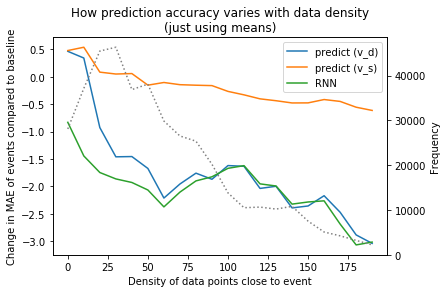

In [67]:
# MAE_dense_predict = np.array(MAE_dense_predict)
MAE_dense2_predict = np.array(MAE_dense2_predict)
MAE_baseline = np.array(MAE_baseline)
# MAE_sparse_predict = np.array(MAE_sparse_predict)
MAE_sparse2_predict = np.array(MAE_sparse2_predict)
# MAE_RNN_predict = np.array(MAE_RNN_predict)


# plt.plot(x, percentages_baseline, label="baseline")
# plt.plot(x, MAE_dense_predict-MAE_baseline, label="predict (d)")
plt.plot(x, MAE_dense2_predict-MAE_baseline, label="predict (v_d)")
# plt.plot(x, MAE_sparse_predict-MAE_baseline, label="predict (s)")
plt.plot(x, MAE_sparse2_predict-MAE_baseline, label="predict (v_s)")
plt.plot(x, MAE_RNN_predict-MAE_baseline, label="RNN")

plt.xlabel("Density of data points close to event")
plt.ylabel("Change in MAE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
# ax2.set_yscale("log")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



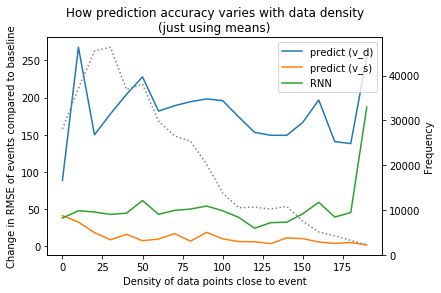

In [69]:
# RMSE_dense_predict = np.array(RMSE_dense_predict)
RMSE_dense2_predict = np.array(RMSE_dense2_predict)
RMSE_baseline = np.array(RMSE_baseline)
# RMSE_sparse_predict = np.array(RMSE_sparse_predict)
RMSE_sparse2_predict = np.array(RMSE_sparse2_predict)
# RMSE_RNN_predict = np.array(RMSE_RNN_predict)


# plt.plot(x, percentages_baseline, label="mean")
# plt.plot(x, RMSE_dense_predict-RMSE_baseline, label="predict (d)")
plt.plot(x, RMSE_dense2_predict-RMSE_baseline, label="predict (v_d)")
# plt.plot(x, RMSE_sparse_predict-RMSE_baseline, label="predict (s)")
plt.plot(x, RMSE_sparse2_predict-RMSE_baseline, label="predict (v_s)")
plt.plot(x, RMSE_RNN_predict-RMSE_baseline, label="RNN")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in RMSE of events compared to baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()



In [ ]:
plt.hist(test_target, bins=100, range=(-100,100), label="target");
plt.hist(test_y, bins=100, range=(-100,100), alpha=0.5, label="RNN");
# plt.hist(st_offsets_dense[cut_point:,0,3], bins=100, range=(-100,100), alpha=0.5, label="Dense");
# plt.hist(offsets_sparse2[cut_point:], bins=100, range=(-100,100), alpha=0.5, label="Sparse");
plt.legend()
plt.yscale("log")


In [72]:
predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(None, test_y.squeeze(), baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, calc_mask=test_mask)


/Users/tommelamed/anaconda3/envs/busses/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less


Approximately 11.60% improvment on baseline
Approximately 44.54% are in 10%


In [ ]:
# show_accuracy_minutes(predict_array_RNN_cum, actual_array_cum, title="RNN")

In [ ]:
# show_accuracy_minutes(baseline_array_cum, actual_array_cum, title="Baseline")

In [ ]:
# show_accuracy_minutes(baseline_median_array_cum, actual_array_cum, title="Baseline Median")

....................................................................................................................................................................................................................................................................................................................

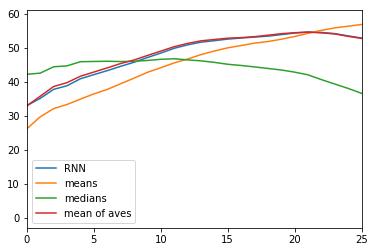

In [73]:
plt.plot(make_accuracy_matrix_minutes(predict_array_RNN_cum, actual_array_cum)[0][0,:], label="RNN")
plt.plot(make_accuracy_matrix_minutes(baseline_array_cum, actual_array_cum)[0][0,:], label="means")
plt.plot(make_accuracy_matrix_minutes(baseline_median_array_cum, actual_array_cum)[0][0,:], label="medians")
plt.plot(make_accuracy_matrix_minutes((baseline_median_array_cum + baseline_array_cum)/2, actual_array_cum)[0][0,:], label="mean of aves")
plt.xlim(0,25)
plt.legend()
plt.show()

In [ ]:
median_pass_fraction

In [34]:
def full_test(dropout, rdropout, loss, filename, replaced=False):
    
    model = create_LSTM_large(
        (train_matrix_st.shape[1], train_matrix_st.shape[2]),
        dropout,
        rdropout,
    )

    Path(f"ST_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"ST_models/" + filename,
            monitor="val_loss",
            save_best_only=True,
        ),
    ]

    # model.compile(optimizer="rmsprop", loss="mean_absolute_error")
    model.compile(optimizer="rmsprop", loss=loss)

    
    if replaced:
        model.fit(
            train_matrix_st_replaced,
            train_target_scaled,
            epochs=100,
            callbacks=callbacks_list,
            batch_size=64,
            validation_data=(test_matrix_st_replaced, test_target_scaled),
        )        
        
        test_y_scaled = model.predict(test_matrix_st_replaced)
    else:
        model.fit(
            train_matrix_st,
            train_target_scaled,
            epochs=100,
            callbacks=callbacks_list,
            batch_size=64,
            validation_data=(test_matrix_st, test_target_scaled),
        )

        test_y_scaled = model.predict(test_matrix_st)
    
    test_y = scaler_target.inverse_transform(test_y_scaled)
    
    print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
    print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
    
    predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=test_baseline_array_cum, actual_array_cum=test_actual_array_cum, calc_mask=test_mask)
    
    return pass_fraction, mean_absolute_error(test_target, test_y), np.sqrt(mean_squared_error(test_target, test_y))

In [ ]:
train_matrix_st_prev_replaced[:,:5,3:8].shape

In [35]:
def full_test_combined(dropout, rdropout, loss, filename, delta, intermediate_weight, matrix, lstm_shape, dense_shape):
    
    if matrix == "st":
        train_mtx = train_matrix_st
        test_mtx = test_matrix_st
        
    if matrix == "replaced":
        train_mtx = train_matrix_st_replaced
        test_mtx = test_matrix_st_replaced
        
    if matrix == "prev":
        train_mtx = train_matrix_st_prev
        test_mtx = test_matrix_st_prev
        
    if matrix == "prev_replaced":
        train_mtx = train_matrix_st_prev_replaced
        test_mtx = test_matrix_st_prev_replaced
        
    if matrix == "prev_replaced_55":
        train_mtx = train_matrix_st_prev_replaced[:,:5,3:8]
        test_mtx = test_matrix_st_prev_replaced[:,:5,3:8]
        
        
    model = create_any_combined_model(
        (train_mtx.shape[1], train_mtx.shape[2]),
        train_matrix_aux.shape[1],
        dropout,
        rdropout,
        lstm_shape,
        dense_shape
    )

    Path(f"ST_models").mkdir(parents=True, exist_ok=True)

    callbacks_list = [
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
        keras.callbacks.ModelCheckpoint(
            filepath=f"ST_models/" + filename,
            monitor="val_loss",
            save_best_only=True,
        ),
    ]
    
    delta = tf.cast(delta,tf.float32)
    
    def huber_loss(y_true, y_pred):
        return tf.losses.huber_loss(y_true,y_pred, delta=delta)

    if loss == 'huber':
        model.compile(optimizer="rmsprop", 
                      loss=huber_loss, 
                      loss_weights=[1, intermediate_weight])
    else:
        model.compile(optimizer="rmsprop", 
                      loss=loss, 
                      loss_weights=[1, intermediate_weight])
        
    
    model.fit(
        [train_mtx,train_matrix_aux],
        [train_target_scaled, train_target_scaled],
        epochs=100,
        callbacks=callbacks_list,
        batch_size=512,
        validation_data=([test_mtx, test_matrix_aux],
        [test_target_scaled, test_target_scaled],),
    )

    test_y_scaled, _ = model.predict([test_mtx, test_matrix_aux])
    
    test_y = scaler_target.inverse_transform(test_y_scaled)
    
    print(f"MAE RNN: {mean_absolute_error(test_target, test_y)}")
    print(f"RMSE RNN: {np.sqrt(mean_squared_error(test_target, test_y))}")
    
    predict_array_RNN_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=test_y.squeeze(), baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, calc_mask=test_mask)
    
    return pass_fraction, mean_absolute_error(test_target, test_y), np.sqrt(mean_squared_error(test_target, test_y))

In [ ]:
with open("combined_test4_5x4_no_aves.csv", "a+") as f: 
#     f.write("dropout,rdropout,loss,matrix,delta,intermediate_weight,lstm_shape,dense_shape,pass_fraction,MSE,RMSE\n")
    f.flush()
    for runs in range(5):
        for i in np.linspace(0,.3,3):
            for j in np.linspace(0,.3,3):
                for i_weight in np.linspace(0,1,3):
                    for loss in ['huber','logcosh']:
                        for matrix in ["prev_replaced_55"]: #, "prev_replaced","st", "replaced", "prev"]:
                            for lstm_shape in [[20,20,20],[40,40],[80]]:
                                for dense_shape in [[32,32,12],[64,32,12],[128,128,64,64,32,32]]:
                                    
                                    lstm_shape_s = "_".join(map(str,lstm_shape))
                                    dense_shape_s = '_'.join(map(str,dense_shape))
                            
                                    pass_frac, MSE, RMSE = full_test_combined(i, j, loss, f"combined_run_{runs}_dropout_{i}_{j}_{loss}_delta_1_iweights_{i_weight}_matrix_{matrix}_l_{lstm_shape_s}_d_{dense_shape_s}.h5", 1, i_weight, matrix, lstm_shape, dense_shape)
                                    f.write(f"{i},{j},{loss},{matrix},1,{i_weight},{lstm_shape_s},{dense_shape_s},{pass_frac},{MSE},{RMSE}\n") 
                                    f.flush()





In [ ]:
with open("combined_test2_11x11.csv", "a+") as f: 
    f.write("dropout,rdropout,loss,matrix,delta,intermediate_weight,pass_fraction,MSE,RMSE\n")
    for runs in range(5):
        for i in np.linspace(0.1,.3,3):
            for j in np.linspace(0.1,.3,3):
                for i_weight in np.linspace(0,1,3):
                    for loss in ['huber','logcosh']:
                        for matrix in ["st", "replaced", "prev"]:
                            
                            if loss == 'huber':
                                for delta in np.linspace(0.5,1.5,3):
                                    pass_frac, MSE, RMSE = full_test_combined(i, j, loss, f"combined_run_{runs}_dropout_{i}_{j}_{loss}_delta_{delta}_iweights_{i_weight}_matrix_{matrix}_80_128_64_32_12_12_1.h5", delta=delta, intermediate_weight=i_weight, matrix=matrix)
                                    f.write(f"{i},{j},{loss},{replaced},{delta},{i_weight},{pass_frac},{MSE},{RMSE}\n")
                                    f.flush()
                            else:
                                pass_frac, MSE, RMSE = full_test_combined(i, j, loss, f"combined_run_{runs}_dropout_{i}_{j}_{loss}_iweights_{i_weight}_matrix_{matrix}_80_128_64_32_12_12_1.h5", delta=1, intermediate_weight=i_weight, matrix=matrix)
                                f.write(f"{i},{j},{loss},{replaced},1,{i_weight},{pass_frac},{MSE},{RMSE}\n") 
                                f.flush()




In [ ]:
show_accuracy_minutes(predict_array_RNN_cum, actual_array_cum, "means")

In [36]:
def percent_in_x_percent(predict, actual, threshold):
    
    if np.count_nonzero(~np.isnan(actual)) == 0:
        return 0, 0
    
    threshold = threshold/100
    
    mask = (~np.isnan(predict) & ~np.isnan(actual))
    
    pass_count = np.count_nonzero((predict[mask] < actual[mask] * (1 + threshold)) & (predict[mask] > actual[mask] * (1-threshold)))
    
    over_count = np.count_nonzero(predict[mask] > actual[mask] * (1+threshold))
    
    under_count = np.count_nonzero(predict[mask] < actual[mask] * (1-threshold))
    
    pass_percent = pass_count/np.count_nonzero(mask) * 100
    
    if over_count + under_count == 0:
        drift = 0.5
    else:
        drift = over_count / (over_count + under_count)
    
    return pass_percent, drift

def make_accuracy_matrix_minutes(predict, actual, max_threshold = 50):

    actual_ints = np.array(actual/60).astype(int)
    
    rows = int(max_threshold/10)
    
    max_a = np.nanmax(actual)/60

    accuracies_table = np.empty((rows, int(max_a)))
    drift_table = np.empty((rows, int(max_a)))
    frequency = np.empty(int(max_a))

    for i in range(int(max_a)):
        print(".", end="", flush=True)
        mask = (actual_ints == i)
        
        frequency[i] = np.count_nonzero(mask)
        
        for j in range(1, rows+1):
            accuracy, drift = percent_in_x_percent(predict[mask], actual[mask], j * 10)
            accuracies_table[j-1,i] = accuracy
            drift_table[j-1, i] = drift

    return accuracies_table, frequency, drift_table

def show_accuracy_minutes(predict, actual, title):
    results, frequency, drift = make_accuracy_matrix_minutes(predict, actual)
    
    for i in range(results.shape[0]):
        plt.plot(results[i,:], label=f"{(i+1)*10}%")
        
        
    plt.xlabel("minutes ahead")
    plt.ylabel("percentage within threshold")
    plt.legend()
    plt.title(title)
    plt.xlim(0,20)
    plt.ylim(0,100)
    plt.gca().yaxis.grid(True, linewidth="0.2")
    
    ax = plt.gca()
    
    ax2 = ax.twinx()
    ax2.plot(drift[0,:], label="fraction over", linestyle=":")
    ax2.set_ylim(0,1)
   
    plt.show()

In [37]:
# From: https://stackoverflow.com/questions/51597849/padding-a-numpy-array-with-offsets-for-each-data-column

def create_padded_array(a, row_start, n_rows):
    r = np.arange(n_rows)[:,None]
    row_start = np.asarray(row_start)
    mask = (r >= row_start) & (r < row_start+a.shape[0])

    out = np.zeros(mask.shape, dtype=a.dtype)
    out[:] = np.nan
    out.T[mask.T] = a.ravel('F')
    return out   

def create_triangle(input_array, max_width=70):
    
    filled_values = np.empty((input_array.shape[0],70)).astype(float)
    
    filled_values[:] = input_array[:,None]
    
    return create_padded_array(filled_values, list(range(70)), input_array.shape[0]+71)[:input_array.shape[0],:]
    
    
    

In [38]:
def calc_baseline_and_actual(calc_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    baseline_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_array[:] = np.nan
    
    actual_array = np.empty((se_min.shape[0],70)).astype(float)
    actual_array[:] = np.nan
    
    baseline_median_array = np.empty((se_min.shape[0],70)).astype(float)
    baseline_median_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    actual_index = se_min.columns.get_loc("segment_duration")
    baseline_index = se_min.columns.get_loc("mean_durations_by_segment_code_and_hour_and_day")
    baseline_median_index = se_min.columns.get_loc("median_durations_by_segment_code_and_hour_and_day")

    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        baseline_array[run.index,:] = create_triangle(run.iloc[:, baseline_index])
        actual_array[run.index,:] = create_triangle(run.iloc[:, actual_index])
        baseline_median_array[run.index,:] = create_triangle(run.iloc[:, baseline_median_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):
 
#             baseline_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, baseline_index]

#             actual_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, actual_index]
            
    baseline_array_cum = np.cumsum(baseline_array, axis=1)
    actual_array_cum = np.cumsum(actual_array, axis=1)
    baseline_median_array_cum = np.cumsum(baseline_median_array, axis=1)
    
    actual_array_cum = np.clip(actual_array_cum, 0, 2*60*60)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = baseline_pass_count/np.count_nonzero(first_20mins_mask)
    
    baseline_median_pass_count = np.count_nonzero((baseline_median_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_median_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    median_pass_fraction = baseline_median_pass_count/np.count_nonzero(first_20mins_mask)
    
    return baseline_array_cum, actual_array_cum, baseline_median_array_cum, baseline_pass_count, pass_fraction, baseline_median_pass_count, median_pass_fraction


In [ ]:
baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(data_mask)

In [40]:
def calc_prediction_cum_journeys(column_name, offsets, baseline_array_cum, actual_array_cum, calc_mask):
    
    if len(calc_mask) == len(data_mask):
        se_min = se[data_mask].copy()
    else:
        se_min = se[data_mask][calc_mask].copy()
    
    if column_name is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (se_min[column_name]/100))
    
    if offsets is not None:
        se_min['prediction'] = se_min['mean_durations_by_segment_code_and_hour_and_day'] * (1 + (offsets.squeeze()/100))
    
    predict_array = np.empty((se_min.shape[0],70)).astype(float)
    predict_array[:] = np.nan
    
    se_min = se_min.reset_index(drop=True)
    
    runs = se_min.groupby(['date','workid'])
    
    prediction_index = se_min.columns.get_loc("prediction")
    
    for name, run in runs:
        run = run.sort_values("actualArrival")
        
        predict_array[run.index,:] = create_triangle(run.iloc[:, prediction_index])

#         run_length = len(run)

#         for i in range(min([run_length, 70])):

#             predict_array[run.iloc[i:].index,i] = run.iloc[:run_length-i, prediction_index]
            
    predict_array_cum = np.cumsum(predict_array, axis=1)
    
    first_20mins_mask = actual_array_cum < 20*60
    
    baseline_pass_count = np.count_nonzero((baseline_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (baseline_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    
    pass_count = np.count_nonzero((predict_array_cum[first_20mins_mask] < actual_array_cum[first_20mins_mask] * 1.1) & \
                    (predict_array_cum[first_20mins_mask] > actual_array_cum[first_20mins_mask] * 0.9))
    
    pass_fraction = pass_count/np.count_nonzero(first_20mins_mask)
        
    print(f"Approximately {(pass_count - baseline_pass_count)/baseline_pass_count*100:0.2f}% improvment on baseline")
    
    print(f"Approximately {pass_fraction*100:0.2f}% are in 10%")
    
    return predict_array_cum, pass_count, pass_fraction
    

In [ ]:
def full_test(slices, threshold, baseline_array_cum, actual_array_cum, column_name=None, axis=(1,2), means=means, counts=counts, data_mask):
    try:
        offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, slices, axis, column_name, threshold)
    except ValueError:
        print("Not enough values passed threshold")
        return [], 0, 0, 0, 0
    
    predict_array_cum, pass_count, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, data_mask=data_mask)
    
    return predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights


In [ ]:
show_accuracy_minutes(baseline_array_cum, actual_array_cum, "means")

In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(1,8), (1,2), None, 40)

predict_array_dense2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=data_size)

show_accuracy_minutes(predict_array_dense2_cum, actual_array_cum, "means")



In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(2,10), (1,2), None, 40)

predict_array_dense_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=data_size)

show_accuracy_minutes(predict_array_dense_cum, actual_array_cum, "means")


In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(8,15), (1,2), None, 60)

predict_array_sparse_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse_cum, actual_array_cum, "means")



In [ ]:
offsets, threshold_pass_fraction, mean_weights = calc_offsets(means, counts, calc_slice(10,20), (1,2), None, 40)

predict_array_sparse2_cum, _, pass_fraction = calc_prediction_cum_journeys(offsets=offsets, baseline_array_cum=baseline_array_cum, actual_array_cum=actual_array_cum, number_of_rows=500000)

show_accuracy_minutes(predict_array_sparse2_cum, actual_array_cum, "means")


In [ ]:
# dense_mask = (bus_counts>40)

# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="mean sparse")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[~dense_mask, :], actual_array_cum[~dense_mask, :])[0][0,:], label="predict sparse")
# plt.plot(make_accuracy_matrix_minutes(baseline_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="mean dense")
# plt.plot(make_accuracy_matrix_minutes(predict_array_cum[dense_mask, :], actual_array_cum[dense_mask, :])[0][0,:], label="predict dense")


# # plt.plot(results_enh7[0,:], label="mean_enh7")
# # plt.plot(predict_array_cum[0,:], label="mean_enh_all")
# # plt.plot(with_15_90[0,:], label="with_15_90")
# # plt.plot(narrow_15_90[0,:], label="narrow_15_90")
# # plt.plot(narrow_15_90_t40[0,:], label="narrow_15_90_t40")
# # plt.plot(wide_15_45_t20[0,:], label="wide_15_45_t20")

# plt.legend()
# plt.xlim(0,20)
# plt.ylim(25,60)
# plt.title("Percentage of predictions within 10%")
# plt.xlabel("minutes ahead")
# plt.ylabel("percent within 10%")
# plt.show()

In [ ]:
first_20mins_mask = actual_array_cum < 20*60

In [ ]:
percentages_baseline = []
percentage_dense2_predict = []
percentage_dense_predict = []
percentage_sparse_predict = []
percentage_sparse2_predict = []
percentage_ave_predict = []

freqeuncy = []

x = np.array(range(27))*10

for i in x:

    if forwards: 
        full_mask = first_20mins_mask & (bus_counts>i)[:data_size,None] & (bus_counts<i+10)[:data_size,None]
    else:
        full_mask = first_20mins_mask & (bus_counts>i)[-data_size:,None] & (bus_counts<i+10)[-data_size:,None]
    
    freqeuncy.append(np.count_nonzero(full_mask))
    
    percentages_baseline.append(np.count_nonzero((baseline_array_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (baseline_array_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_dense2_predict.append(np.count_nonzero((predict_array_dense2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
        
    percentage_dense_predict.append(np.count_nonzero((predict_array_dense_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_dense_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse_predict.append(np.count_nonzero((predict_array_sparse_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    
    percentage_sparse2_predict.append(np.count_nonzero((predict_array_sparse2_cum[full_mask] < actual_array_cum[full_mask] * 1.1) & \
                    (predict_array_sparse2_cum[full_mask] > actual_array_cum[full_mask] * 0.9))/np.count_nonzero(full_mask)*100)
    

In [ ]:
percentage_dense_predict = np.array(percentage_dense_predict)
percentage_dense2_predict = np.array(percentage_dense2_predict)
percentages_baseline = np.array(percentages_baseline)
percentage_sparse_predict = np.array(percentage_sparse_predict)
percentage_sparse2_predict = np.array(percentage_sparse2_predict)


# plt.plot(x, percentages_baseline, label="mean")
plt.plot(x, percentage_dense_predict-percentages_baseline, label="predict (d)")
plt.plot(x, percentage_dense2_predict-percentages_baseline, label="predict (v_d)")
plt.plot(x, percentage_sparse_predict-percentages_baseline, label="predict (s)")
plt.plot(x, percentage_sparse2_predict-percentages_baseline, label="predict (v_s)", ls=":")
plt.xlabel("Density of data points close to event")
plt.ylabel("Change in % of events within 10% of true\nCompared to Baseline")
plt.legend(loc=1)
# plt.ylim(35,47)

ax = plt.gca()

ax2 = ax.twinx()
 
ax2.plot(x, freqeuncy, c="grey", ls=":")
ax2.set_ylabel("Frequency")
plt.title("How prediction accuracy varies with data density\n(just using means)")
# plt.savefig("accuracy vs density_2m_forward.pdf")
plt.show()


In [ ]:
# baseline_array_cum, actual_array_cum, baseline_pass_count = calc_baseline_and_actual(500000)

In [ ]:
# with open("post_noise_width_time_threshold_test3.csv", "w") as f: 
#     f.write("width,time,threshold,threshold_pass_fraction,mean_weights,pass_count,pass_fraction\n")
#     for width in range(0,12,2):
#         for time in range(2,24,3):
#             for threshold in [0,20,40,60,80,100,120,140,160,180,200,250,300]:
#                 print(f"w: {width}, t:20-{(time+3)*10}, t:{threshold}")
#     #             _, _, _, pass_count = full_test(np.s_[:,1:time+2,7-width:7+width+1], threshold, number_of_rows=50000)
#                 predict_array_cum, pass_count, pass_fraction, threshold_pass_fraction, mean_weights = full_test(np.s_[:,2:time+3,11-width:11+width+1], threshold, baseline_array_cum, actual_array_cum, number_of_rows=500000)
        
#                 f.write(f"{width},{(time+3)*10},{threshold},{threshold_pass_fraction},{mean_weights},{pass_count},{pass_fraction}\n")
#                 f.flush()
    
            
            